In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods, txtbox512
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import tf_extended as tfe
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
from processing import tf_image
import cv2
import matplotlib.pylab as plt


In [3]:
isess = tf.InteractiveSession()

In [4]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    print (np.array(xmax)-np.array(xmin))*1.0 / (np.array(ymax)-np.array(ymin))
    plt.imshow(image)
    plt.show()

In [14]:
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]
anchor_sizes=[(21., 51.),
              (51., 99.),
              (133., 153.),
              (215., 207.),
              (296., 261.),
              (379., 315.),
              (461, 543.)]
scale_range=[0.05, 0.75]
scale_range_max = [0.1, 0.9]
scales = [scale_range[0] + i*(scale_range[1] - scale_range[0])/6  for i in range(6)]
scales_max = [scale_range_max[0] + i*(scale_range_max[1] - scale_range_max[0])/6  for i in range(7)]
anchor_sizes = [(300*scales[i], 300*scales_max[i]) for i in range(6)]
anchor_sizes=[(21., 45.),
		  (45., 99.),
		  (99., 153.),
		  (153., 207.),
		  (207., 261.),
		  (261., 315.)]

anchor_sizes



[(21.0, 45.0),
 (45.0, 99.0),
 (99.0, 153.0),
 (153.0, 207.0),
 (207.0, 261.0),
 (261.0, 315.0)]

text_shape (300, 300)
0.5
file_path: ../data/sythtext/3.tfrecord
[[61], [0], [177], [182]]
[ 1.56896552]


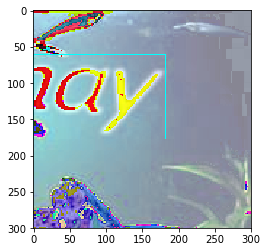

[[61], [0], [177], [182]]
[ 1.56896552]


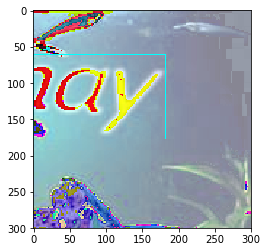

[[210, 192], [48, 68], [230, 216], [110, 120]]
[ 3.1         2.16666667]


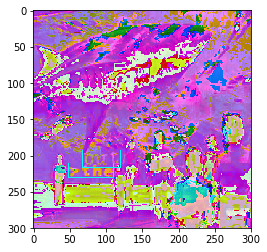

[[192, 210], [68, 48], [216, 230], [120, 110]]
[ 2.16666667  3.1       ]


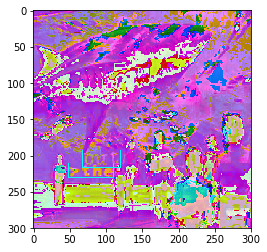

[[139, 210, 244, 261], [146, 140, 274, 292], [163, 245, 258, 272], [201, 217, 300, 300]]
[ 2.29166667  2.2         1.85714286  0.72727273]


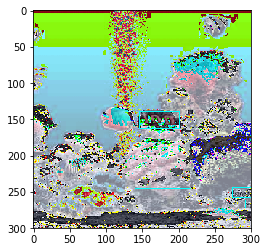

[[139, 210, 244], [146, 140, 274], [163, 245, 258], [201, 217, 300]]
[ 2.29166667  2.2         1.85714286]


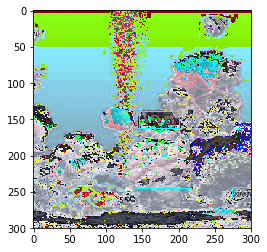

[[113], [0], [178], [86]]
[ 1.32307692]


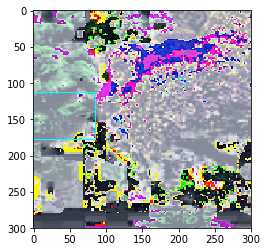

[[113], [0], [178], [86]]
[ 1.32307692]


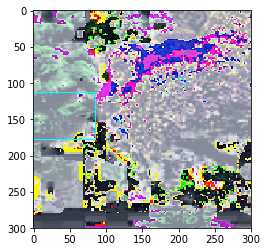

[[161, 193], [175, 190], [210, 215], [218, 237]]
[ 0.87755102  2.13636364]


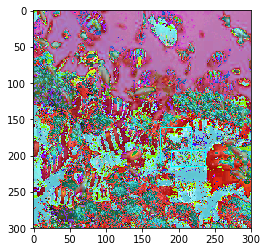

[[193, 161], [190, 175], [215, 210], [237, 218]]
[ 2.13636364  0.87755102]


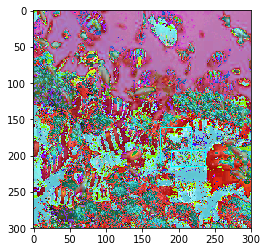

[[273, 115, 19, 39, 21, 257, 69, 13, 34, 28], [216, 59, 115, 110, 205, 210, 114, 125, 123, 199], [292, 148, 29, 51, 65, 282, 84, 23, 44, 48], [240, 100, 132, 131, 252, 252, 139, 150, 150, 223]]
[ 1.26315789  1.24242424  1.7         1.75        1.06818182  1.68
  1.66666667  2.5         2.7         1.2       ]


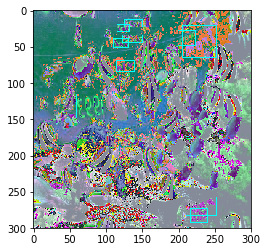

[[19, 34, 28, 115, 257, 13, 39, 21, 273], [115, 123, 199, 59, 210, 125, 110, 205, 216], [29, 44, 48, 148, 282, 23, 51, 65, 292], [132, 150, 223, 100, 252, 150, 131, 252, 240]]
[ 1.7         2.7         1.2         1.24242424  1.68        2.5         1.75
  1.06818182  1.26315789]


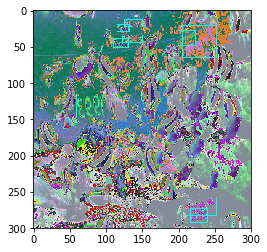

[[25, 0, 61, 57], [178, 142, 164, 254], [78, 43, 119, 99], [272, 254, 227, 300]]
[ 1.77358491  2.60465116  1.0862069   1.0952381 ]


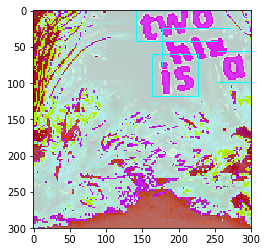

[[0, 25, 61, 57], [142, 178, 164, 254], [43, 78, 119, 99], [254, 272, 227, 300]]
[ 2.60465116  1.77358491  1.0862069   1.0952381 ]


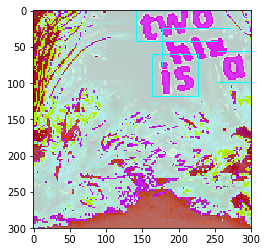

[[10, 34], [17, 17], [28, 54], [111, 105]]
[ 5.22222222  4.4       ]


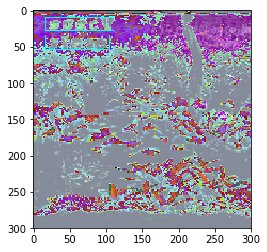

[[10, 34], [17, 17], [28, 54], [111, 105]]
[ 5.22222222  4.4       ]


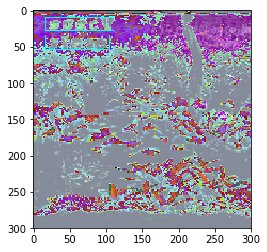

[[187, 116, 160, 203], [235, 0, 0, 0], [253, 152, 206, 246], [300, 52, 65, 71]]
[ 0.98484848  1.44444444  1.41304348  1.65116279]


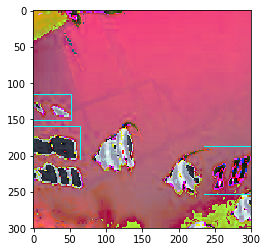

[[116, 160, 187, 203], [0, 0, 235, 0], [152, 206, 253, 246], [52, 65, 300, 71]]
[ 1.44444444  1.41304348  0.98484848  1.65116279]


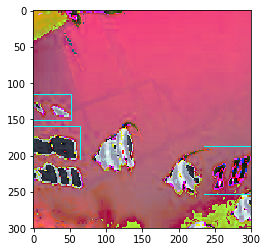

[[0, 291], [66, 0], [33, 300], [161, 36]]
[ 2.87878788  4.        ]


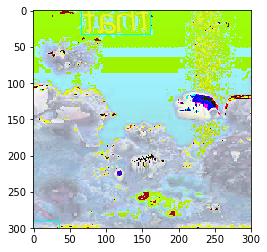

[[291, 0], [0, 66], [300, 33], [36, 161]]
[ 4.          2.87878788]


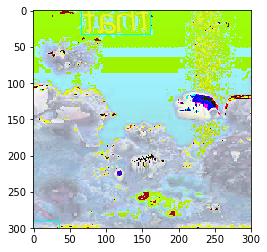

434
{1: array([[[ 0.9701407 ,  0.00183898,  1.        ,  0.12058198],
        [ 0.        ,  0.22030813,  0.11223614,  0.5387336 ]]], dtype=float32)}
2.0


In [26]:
out_shape = [500,700]
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='3.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, height,width,
                                            text_shape,data_format = 'NHWC',is_training=True)
    b_gdifficults = tf.zeros(tf.shape(glabels), dtype=tf.int64)
    #image = (dst_image - tf.reduce_min(dst_image))/ (tf.reduce_max(dst_image) - tf.reduce_min(dst_image))
    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    logits = []
    predictions = []
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
        logits.append(tf.cast(gscores[i] > 0.5, tf.int32))
        predictions.append(tf.one_hot(logits[i],axis=-1,depth=2,off_value=0.0,on_value=1.0))
    localisations = text_net.bboxes_decode(glocalisations, text_anchors)
    rscores, rbboxes = \
    text_net.detected_bboxes(predictions, localisations,
                            select_threshold=0.01,
                            nms_threshold=0.5,
                            clipping_bbox=None,
                            top_k=400,
                            keep_top_k=400)

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            error = []
            box = []
            ws = []
            hs = []
            sum0 = 0
            for i in xrange(10):
                rpredictions, rlocalisations, img ,gbboxes_, pre_box_= \
                                        sess.run([gscores, glocalisations,dst_image,gbboxes,rbboxes])
                #num_boxes, tp_, fp_, rscores_ = sess.run([num_gbboxes, tp, fp, rscores])
                
                for i in range(6):
                    sum0 += np.sum(rpredictions[i] > 0.5)
                error.append(gbboxes_.shape[0] - np.ceil(np.sum(pre_box_[1][0] > 0) /4.))
                #img = img * 255
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                img_ = image_.copy()
                visualize_bbox(img_, pre_box_[1][0])
            print sum0
            print pre_box_
            print np.sum(error)
            

file_path: ../data/ICDAR2013/*.tfrecord
{'global': <tf.Tensor 'text_box_300/global/conv3x3/Relu:0' shape=(1, 1, 1, 256) dtype=float32>, 'conv3': <tf.Tensor 'text_box_300/conv3/conv3_3/Relu:0' shape=(1, 75, 75, 256) dtype=float32>, 'conv2': <tf.Tensor 'text_box_300/conv2/conv2_2/Relu:0' shape=(1, 150, 150, 128) dtype=float32>, 'conv1': <tf.Tensor 'text_box_300/conv1/conv1_2/Relu:0' shape=(1, 300, 300, 64) dtype=float32>, 'conv10': <tf.Tensor 'text_box_300/conv10/conv3x3/Relu:0' shape=(1, 3, 3, 256) dtype=float32>, 'conv7': <tf.Tensor 'text_box_300/conv7/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv6': <tf.Tensor 'text_box_300/conv6/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv5': <tf.Tensor 'text_box_300/conv5/conv5_3/Relu:0' shape=(1, 19, 19, 512) dtype=float32>, 'conv4': <tf.Tensor 'text_box_300/conv4/conv4_3/Relu:0' shape=(1, 38, 38, 512) dtype=float32>, 'conv9': <tf.Tensor 'text_box_300/conv9/conv3x3/Relu:0' shape=(1, 5, 5, 256) dtype=float32>, 'conv8': <tf.Tensor 't

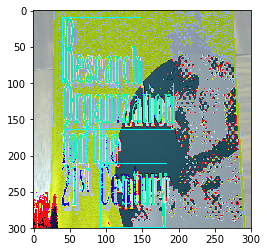

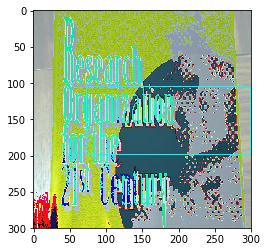

In [17]:
DATA_FORMAT = 'NHWC'
with tf.Graph().as_default(): 
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    text_anchors = text_net.anchors(text_shape)
    #print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    image, glabels, gbboxes,bbox_img, num = \
    txt_preprocessing.preprocess_image(image, glabels,gbboxes, 
                                            text_shape,is_training=False)
    
    glocalisations, gscores = \
        text_net.bboxes_encode( gbboxes, text_anchors, num)

    b_image, glabels, b_gbboxes, g_bbox_img, b_glocalisations, b_gscores  = \
        [tf.expand_dims(image, 0),tf.expand_dims(glabels, 0), tf.expand_dims(gbboxes, 0), bbox_img,glocalisations, gscores]
    #b_image = tf.expand_dims(b_image, 0)
    b_gdifficults = tf.zeros(tf.shape(glabels), dtype=tf.int64)
    dict_metrics = {}
    arg_scope = text_net.arg_scope(data_format=DATA_FORMAT)
    with slim.arg_scope(arg_scope):
        localisations, logits, end_points  = \
            text_net.net(b_image, is_training=False, use_batch=True, reuse=None)

    predictions = []
    for i in range(len(logits)):
        predictions.append(tf.nn.softmax(logits[i]))

    localisations = text_net.bboxes_decode(localisations, text_anchors)
    
    rscores, rbboxes = \
        text_net.detected_bboxes(predictions, localisations,
                                select_threshold=0.5,
                                nms_threshold=0.45,
                                clipping_bbox=None,
                                top_k=400,
                                keep_top_k=200)
    # Compute TP and FP statistics.
    num_gbboxes, tp, fp, rscores = \
        tfe.bboxes_matching_batch(rscores.keys(), rscores, rbboxes,
                                  glabels, b_gbboxes, b_gdifficults,
                                  matching_threshold=0.45)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, '../checkpoints/model.ckpt-182167')
        #print tf.all_variables()
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                gbboxes_,image_,pre_box_,fp_,tp_,num_box,rscores_= \
                        sess.run([gbboxes,image,rbboxes,fp,tp,num_gbboxes,rscores])
                print image_.shape
                img = image_ *255
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                img_ = image_.copy()
                visualize_bbox(img_, pre_box_[1][0])
  

In [18]:
print fp_,tp_,num_box,rscores_

{1: array([[ True]], dtype=bool)} {1: array([[False]], dtype=bool)} {1: array([6])} {1: array([[ 0.50919282]], dtype=float32)}


In [ ]:
row_indices = tf.constant([1, 1, 2])
col_indices = tf.constant([0, 2, 3])
x = tf.zeros((3,4))
coords = tf.transpose(tf.stack([row_indices, col_indices]))
# get tensor with 1's at positions (row1, col1),...
binary_mask = tf.sparse_to_dense(coords, (3,4), 1)

# convert 1/0 to True/False
binary_mask = tf.cast(binary_mask, tf.bool)

twos = 2*tf.ones((3,4))

# make new x out of old values or 2, depending on mask 
x = tf.where(binary_mask, twos, x)

print x.eval()
print tf.gather_nd(x, coords).eval()

In [ ]:
print coords.eval()
print tf.where(x > 0.).eval()